In [1]:
import os
import re

os.chdir("/home/s2113174/Projects-1")

from Galab import llaplace as llp1
from GaLa_v3 import llaplace as llp2

import torch
from torch.autograd import Variable, grad

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from pyDOE import lhs

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Burgers Equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

## Feed Forward Neural Network

In [2]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Burgers Equation definition for the NN

In [3]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u.reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return f

def ini_c(self,data_inic):
    u = self(data_inic)
    return u + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [4]:
DNN.de = de
DNN.ini_c = ini_c
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [5]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [6]:
def data_pde(size,maxl,minp,maxp):

    xy, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [7]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
     
     print("Starting Adam Training")

     for i in range(epochs):
        pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,bound_limit,minval_param,maxval_param)
        
        pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(15):
                optimizer.zero_grad()

                pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                loss_pde,loss_ini = loss(pde_pred,torch.zeros_like(pde_pred)),loss(ini_c_pred,torch.zeros_like(pde_pred))
                loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

                Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc

                if epochs % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()

In [8]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
    
    print("Starting Training: LBFGS optimizer")

    pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,bound_limit,minval_param,maxval_param)
    
    pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        loss_pde,loss_ini = loss(pde_pred,torch.zeros_like(pde_pred)),loss(ini_c_pred,torch.zeros_like(pde_pred))
        loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

        Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc

        print('Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                                            Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))

        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 

In [9]:
# Number of observations
epochs = 1200
nobs = 3000
lr = 0.01

min_param , max_param = 0.0001, 0.05

space = 1

layers = [3] + 4*[30] + [1]


In [10]:
model = DNN(layers)

model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/BurgEq_4_30.pt"))
model.eval()

# loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# dta_set = train_adam(model,loss,optimizer,epochs, nobs,space,min_param,max_param)

# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )

# train_LBFGS(model,loss,optimizer, nobs,space,min_param,max_param)

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=30, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=30, out_features=30, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=30, out_features=1, bias=True)
  )
)

(100, 100)


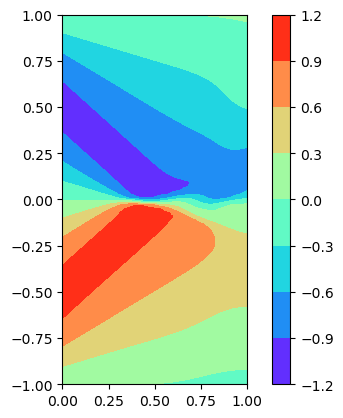

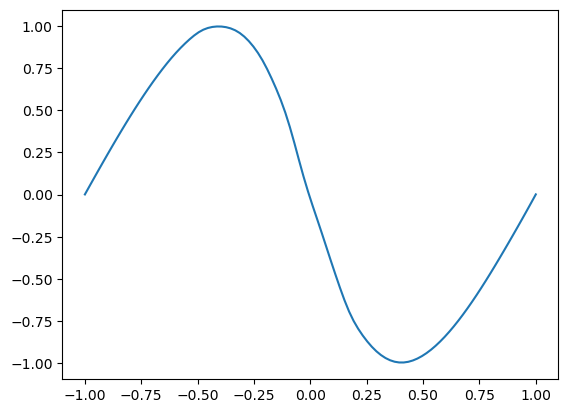

In [11]:
x = np.linspace(-1,1,100)
y = np.linspace(0,1,100)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star = torch.cat([xx,yy,torch.ones_like(xx)*(0.001/np.pi)],axis = 1)

znn = model(X_star)

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn.detach().numpy().flatten(), (xx,yy), method='cubic')

print(U_pred.shape)

h = plt.contourf(y.flatten(), x.flatten(), U_pred.T,cmap='rainbow')


plt.axis('scaled')
plt.colorbar()
plt.show()
plt.plot(x,U_pred[10,:])

In [12]:
x, y = np.linspace(-1,1,100), np.linspace(0,1,100)

xx,yy = np.meshgrid(x, y)

pde_domain,ini_c,left_bc,right_bc = data_pde(nobs,space,min_param,max_param)

pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain,requires_grad=True),
                   "ini_c" : ini_c,
                   "left_bc":left_bc,
                   "right_bc" :right_bc}}

In [13]:
llp = llp1(model,sigma_noise=1, prior_precision=1)
llp.fit(pde=pde, hessian_structure = "full")


# log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
# hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
# for i in range(1000):
#     hyper_optimizer.zero_grad()
#     neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#     neg_marglik.backward(retain_graph=True)
#     hyper_optimizer.step()
#     print(log_prior,log_sigma)

In [14]:
llp2 = llp2(model,sigma_noise=1, prior_precision=1)
llp2.fit(pde=pde, hessian_structure = "full")

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - llp2.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)
    hyper_optimizer.step()
    print(log_prior,log_sigma)

tensor([1.1000], requires_grad=True) tensor([0.9000], requires_grad=True)
tensor([1.2000], requires_grad=True) tensor([0.8000], requires_grad=True)
tensor([1.2999], requires_grad=True) tensor([0.7000], requires_grad=True)
tensor([1.3998], requires_grad=True) tensor([0.6001], requires_grad=True)
tensor([1.4995], requires_grad=True) tensor([0.5001], requires_grad=True)
tensor([1.5990], requires_grad=True) tensor([0.4002], requires_grad=True)
tensor([1.6983], requires_grad=True) tensor([0.3003], requires_grad=True)
tensor([1.7971], requires_grad=True) tensor([0.2006], requires_grad=True)
tensor([1.8953], requires_grad=True) tensor([0.1009], requires_grad=True)
tensor([1.9928], requires_grad=True) tensor([0.0013], requires_grad=True)
tensor([2.0892], requires_grad=True) tensor([-0.0981], requires_grad=True)
tensor([2.1843], requires_grad=True) tensor([-0.1974], requires_grad=True)
tensor([2.2776], requires_grad=True) tensor([-0.2963], requires_grad=True)
tensor([2.3688], requires_grad=True

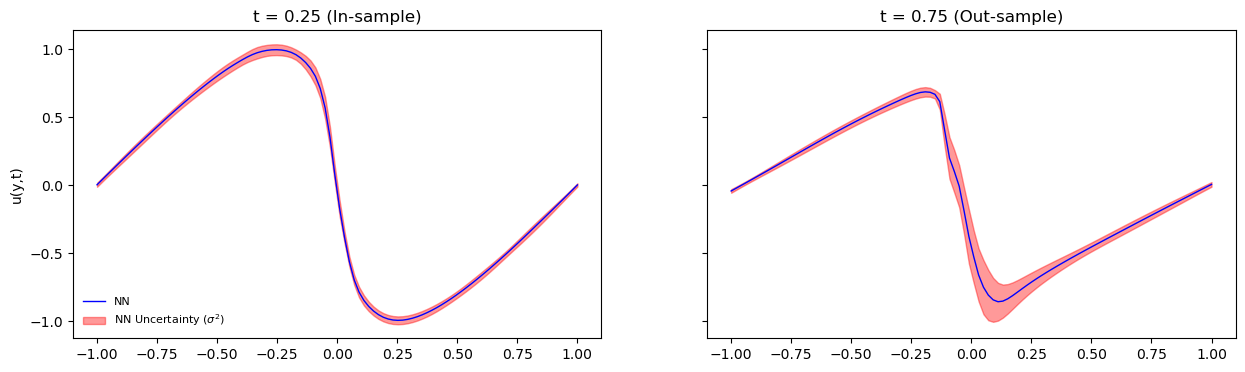

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,4), sharey=True,sharex=True)
plt.rcParams.update({'font.size': 10})
zz= 25
pr = (0.001/np.pi)


X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

f_mu, f_sigma = llp(X_star)

f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()


z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')


axs[0].set_title(fr"t = 0.25 (In-sample)",color = "black")
axs[0].plot(x,z_pred[zz,:],color = "blue", label = f"NN",linewidth=1)
axs[0].fill_between(x.reshape(-1), z_pred[zz,:]+2*z_pred_var[zz,:],z_pred[zz,:]-2*z_pred_var[zz,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
axs[0].set_ylabel(r'u(y,t)')
axs[0].legend(frameon = False, prop={'size': 8},loc='lower left')

axs[1].set_title(fr"t = 0.75 (Out-sample)",color = "black")
axs[1].plot(x,z_pred[zz +50,:],color = "blue",linewidth=1)
axs[1].fill_between(x.reshape(-1), z_pred[zz +50,:]+2*z_pred_var[zz +50,:],z_pred[75,:]-2*z_pred_var[zz +50,:],alpha=0.4, color = "red")
#axs[1].legend(frameon = False, prop={'size': 8},loc='lower left')

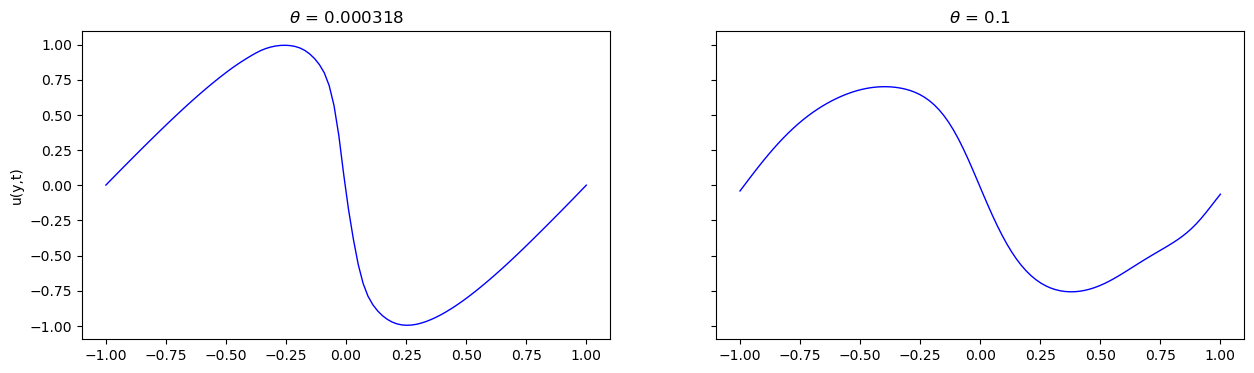

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15,4), sharey=True,sharex=True)
plt.rcParams.update({'font.size': 10})
zz= 25
pr = (0.001/np.pi)


X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

f_mu, f_sigma = llp(X_star)

f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()


z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')


axs[0].set_title(fr"$\theta$ = {pr:0.3}",color = "black")
axs[0].plot(x,z_pred[zz,:],color = "blue", label = f"NN",linewidth=1)
axs[0].set_ylabel(r'u(y,t)')



pr = (0.1)

X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

f_mu, f_sigma = llp(X_star)

f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()


z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')



axs[1].set_title(fr"$\theta$ = {pr}",color = "black")
axs[1].plot(x,z_pred[zz,:],color = "blue",linewidth=1)
#axs[1].fill_between(x.reshape(-1), z_pred[zz +50,:]+2*z_pred_var[zz +50,:],z_pred[75,:]-2*z_pred_var[zz +50,:],alpha=0.4, color = "red")
#axs[1].legend(frameon = False, prop={'size': 8},loc='lower left')